# Récupération des données

In [1]:
%autosave 0
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adamax
import tensorflow

from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.model_selection import KFold

%matplotlib inline
pandas.set_option('display.width', 100)
pandas.set_option('precision', 3)

tensorflow.random.set_seed(15)
numpy.random.seed(15)

Autosave disabled


Using TensorFlow backend.


In [2]:
Y_trainfull = numpy.load('Y_train.npy')

In [3]:
X_trainfull = numpy.load('X_train.npy')

In [4]:
print(X_trainfull.shape)
print(Y_trainfull.shape)

(2062, 64, 64)
(2062, 10)


In [5]:
X_trainfull = numpy.expand_dims(X_trainfull, axis=X_trainfull.ndim)
X_trainfull.shape

(2062, 64, 64, 1)

In [6]:
# numpy.stack(X_train, X_train, X_train, axis=3)

X_trainfull_vide = numpy.empty([X_trainfull.shape[0], X_trainfull.shape[1], X_trainfull.shape[2], 3])
X_trainfull_vide[..., :] = X_trainfull[..., :]
X_trainfull = X_trainfull_vide

X_trainfull.shape

(2062, 64, 64, 3)

In [7]:
def Y_transform(Y):
    Y_output = []
    for line in range(len(Y)):
        for col in range(10):
            value = str(int(Y[line][col]))
            if value == '1':
                Y_output += [str(col)]

    return Y_output

# Data augmentation

## Création du générateur

In [8]:
alteration = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=10,
    height_shift_range=10,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format='channels_last',
    validation_split=0.0,
    interpolation_order=1,
    dtype='float32')

In [9]:
augmentation = alteration.flow(X_trainfull,
                               y=None,
                               batch_size=len(X_trainfull),
                               shuffle=False,
                               sample_weight=None,
                               seed=None,
                               save_to_dir=None,
                               save_prefix='',
                               save_format='png',
                               subset=None
                              )

## Générations des images

In [10]:
Y_trainfull_or = Y_trainfull
for i in range(4):
    Y_trainfull = numpy.append(Y_trainfull, Y_trainfull_or, axis=0)
    if i == 0:
        images_altered_all = augmentation.next()
    else:
        images_altered = augmentation.next()
        images_altered_all = numpy.append(images_altered_all, images_altered, axis=0)

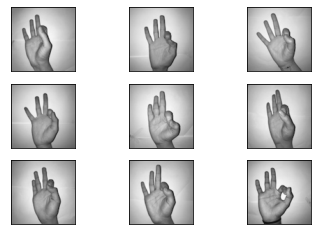

In [11]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_trainfull[i]);
    plt.xticks([]), plt.yticks([]);

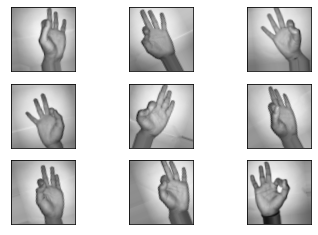

In [12]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images_altered[i]);
    plt.xticks([]), plt.yticks([]);

In [13]:
X_trainfull = numpy.append(X_trainfull, images_altered_all, axis=0)
X_trainfull.shape

(10310, 64, 64, 3)

In [14]:
Y_trainfull.shape

(10310, 10)

# Modèle pré-entraîné avec évaluation K-fold

In [15]:
folds = 10
kfold = KFold(n_splits=folds, shuffle=True, random_state=15)

## Features intermédiaires de mobilenet (modèle pré-entrainé)

In [16]:
pretrained_model = MobileNet(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
for i in range(41):
    model.add(pretrained_model.layers[i])
    
pretrained_model = model

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [17]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 32, 32, 32)       

## Super-modèle basé sur pretrained features

In [40]:
model = Sequential()
model.add(Dense(10, input_shape=pretrained_model.get_output_shape_at(-1)[1:]))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

loss = 'categorical_crossentropy'
LEARNING_RATE = 0.007
EPOCHS = 500

model.compile(loss=loss,
              optimizer=Adamax(lr=LEARNING_RATE), # SGD(lr=LEARNING_RATE)
              metrics=['accuracy'])

## Evaluation en K-fold du modèle

In [ ]:
cvscores = []

for train, val in kfold.split(X_trainfull, Y_trainfull):
    X_train_pretrained_features = pretrained_model.predict(X_trainfull[train])
    x_val_pretrained_features = pretrained_model.predict(X_trainfull[val])
    
    history = model.fit(X_train_pretrained_features,
                        Y_trainfull[train],
                        epochs=EPOCHS,
                        validation_data=(x_val_pretrained_features, Y_trainfull[val]),
                        batch_size=X_train_pretrained_features.shape[0],
                        verbose=0)
    
    scores = model.evaluate(x_val_pretrained_features, Y_trainfull[val], verbose=0)
    cvscores.append(scores[1] * 100)
    
    print(f"étapes terminée : {len(cvscores)} / {folds}")

In [ ]:
for scores in cvscores:
    print(f"{round(scores,1)}%")

print(f"\n{model.metrics_names[1]}: {round(numpy.mean(cvscores),1)}% +/- {round(numpy.std(cvscores),1)}%")

In [ ]:
model.summary()

In [ ]:
# model.save('model.h5')
# model.save_weights('model_weight.h5') >= sauvegarder que les poids appris (et pas ceux du modèle pré-entraîné)

In [ ]:
import pandas as pd
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(15,8))

plt.plot(history.history['loss'][4:], label='loss')
plt.plot(history.history['val_loss'][4:], c = 'black', label='val_loss')
plt.legend()

ax2 = ax1.twinx()
plt.plot(history.history['accuracy'][4:], c = 'orange', label='accuracy')
plt.plot(history.history['val_accuracy'][4:], c = 'red', label='val_accuracy')
plt.legend()

plt.grid(True)
plt.title('Model performance throughout training')
plt.xlabel('epoch');

In [ ]:
y_predict = model.predict(x_val_pretrained_features)

In [ ]:
conf_matrix = metrics.confusion_matrix(y_predict.argmax(axis=1), Y_trainfull[val].argmax(axis=1))
print(conf_matrix)
plt.imshow(conf_matrix, cmap='binary');